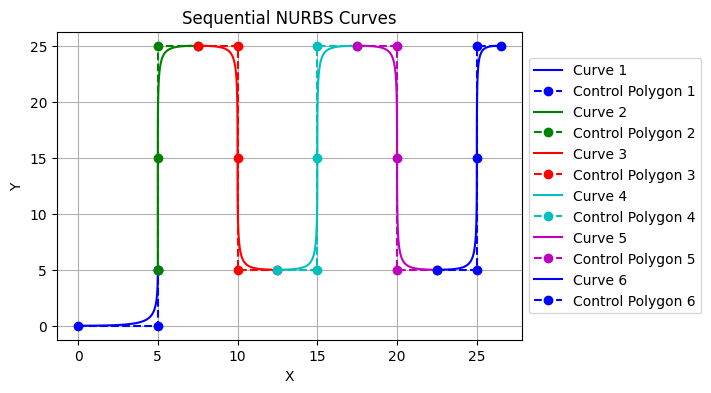

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from geomdl import NURBS
import cadquery as cq
from cadquery import exporters
import math
import PySimpleGUI as sg
import cq_editor as cqe

def get_user_input():
    sg.theme('DarkBlue3')  # Optional theme

    layout = [
        [sg.Text('Set Parameters')],
        [sg.Text('Number of Curves:', size=(25, 1)), sg.InputText(default_text='5', key='n_curves')],
        [sg.Text('Cap Height:', size=(25, 1)), sg.InputText(default_text='5', key='cap_height')],
        [sg.Text('Cap Length:', size=(25, 1)), sg.InputText(default_text='5', key='cap_length')],
        [sg.Text('Thickness:', size=(25, 1)), sg.InputText(default_text='1', key='thickness')],
        [sg.Text('Amplitude:', size=(25, 1)), sg.InputText(default_text='20', key='amplitude0')],
        [sg.Text('Period:', size=(25, 1)), sg.InputText(default_text='10', key='period0')],
        [sg.Text('CP1 Weight:', size=(25, 1)), sg.InputText(default_text='3', key='cp1_weight')],
        [sg.Text('CP3 Weight:', size=(25, 1)), sg.InputText(default_text='3', key='cp3_weight')],
        [sg.Submit(), sg.Cancel()]
    ]

    window = sg.Window('Parameter Input', layout)

    while True:
        event, values = window.read()
        if event == 'Submit':
            try:
                # Process and validate input
                params = {
                    'n_curves': int(values['n_curves']),
                    'cap_height': float(values['cap_height']),
                    'cap_length': float(values['cap_length']),
                    'thickness': float(values['thickness']),
                    'amplitude0': float(values['amplitude0']),
                    'period0': float(values['period0']),
                    'cp1_weight': float(values['cp1_weight']),
                    'cp3_weight': float(values['cp3_weight']),
                }
                # Close the window and return parameters
                window.close()
                return params
            except ValueError as e:
                sg.popup_error(f'Invalid input: {e}')
        elif event == sg.WIN_CLOSED or event == 'Cancel':
            window.close()
            exit()

# # Global Parameters (These can remain at the top)
# n_curves = 5  # Number of sequential NURBS curves

# # Knot vector parameters
# degree = 3
# order = degree + 1
# knot_c = 1

# # Geometry Parameters
# start_x = 0
# start_y = 0
# cap_height = 5
# cap_length = 5
# thickness = 1
# revolve_offset = thickness
# amplitude0 = 20
# period0 = 10
# period_values = [period0 * 1, period0 * 1, period0 * 1]
# offset_factor_x0 = 0          # [x <= 1]
# offset_factor_y0 = 1          # [x <= 1]
# mid_factor_x = 0              # [-1 < x < 1]
# mid_factor_y = 0              # [-1 < x < 1]
# min_y_positions = [start_y, 0, 0]  # Adjust these values as needed
# true_mid = 1  # 1 = fixed to start/end y-position, 0 = relative to mid-point y-position
# rel_mid = 1 - true_mid

# # Weights for the control points
# degree0 = 2
# cp1_weight = 3
# cp3_weight = 3
# cp1_weight0 = 3
# weights = [1, cp1_weight, 1, cp3_weight, 1]
# weights0 = [1, cp1_weight0, 1]

# # Resolution of the NURBS curves (number of points)
# resolution = 100

def validate_parameters(n_curves, period_values, min_y_positions):

    # Number of periods (assuming each period consists of 2 curves)
    n_periods = int(np.ceil(n_curves / 2))
    n_descending_curves = int(np.floor(n_curves / 2))
    if len(min_y_positions) < n_descending_curves + 1:
        raise ValueError('Length of min_y_positions must be at least {}'.format(n_descending_curves + 1))
    elif len(period_values) < n_periods:
        raise ValueError('Length of period_values must be at least {}'.format(n_periods))
    elif len(min_y_positions) > n_descending_curves + 1:
        # If there are extra min_y_positions, give warning but compute anyway
        min_y_positions = min_y_positions[:n_descending_curves + 1]
        print('Warning: Length of min_y_positions greater than the number of descending curves.')
        print('Using the first {} elements.'.format(n_descending_curves + 1))
    elif len(period_values) > n_periods:
        # If there are extra period_values, give warning but compute anyway
        period_values = period_values[:n_periods]
        print('Warning: Length of period_values greater than the number of periods.')
        print('Using the first {} elements.'.format(n_periods))

    return n_periods, n_descending_curves

def compute_x_increments_and_y_positions(n_curves, start_y, amplitude0, period_values, min_y_positions):
    # Initialize x_increments and y_positions arrays
    x_increments = [0] * n_curves
    y_positions = [0] * (n_curves + 1)
    y_positions[0] = start_y

    # Compute x_increments and y_positions
    p = 0  # Period counter
    for i in range(n_curves):
        if i % 2 == 0:  # Ascending curve
            amplitude = amplitude0 - min_y_positions[p]
            y_positions[i + 1] = y_positions[i] + amplitude
            x_increments[i] = period_values[p] / 2
        else:  # Descending curve
            y_positions[i + 1] = min_y_positions[p + 1]
            x_increments[i] = period_values[p] / 2
            p += 1
    return x_increments, y_positions

def generate_cap_curve(start_x, start_y, cap_height, cap_length, weights0, degree0):

    # Initialize lists to collect all curve points and control points and respective index's
    all_control_points = []
    all_curve_points = []
    control_points_idx = []
    control_points_idx_names = []
    curve_points_idx = []
    curve_points_idx_names = []

    # Initial curve for cap end height and length
    cp0_x0 = start_x
    cp0_y0 = start_y

    cp1_x0 = cap_length
    cp1_y0 = start_y

    cp2_x0 = cap_length
    cp2_y0 = cap_height

    control_points0 = [
        [cp0_x0, cp0_y0],
        [cp1_x0, cp1_y0],
        [cp2_x0, cp2_y0],
    ]
    all_control_points.append(control_points0)

    # Create index vector for curve0 and add to control_points_idx
    curve0_cp_idx = np.arange(1, len(control_points0) + 1)
    control_points_idx.append(curve0_cp_idx)
    control_points_idx_names.append(['curve0'])

    # Weights for the control points 0
    curve_weight0 = weights0

    # Knot vector 0 parameters
    order0 = degree0 + 1
    knot_c0 = 1

    # knot elements must equal n + 1 + k, where n+1 is the number of control points and k is the order of the curve; k = degree + 1
    # compute n-k+1 = internal knots
    no_control_points0 = len(control_points0)
    knot_vector_length0 = no_control_points0 + order0
    n0 = no_control_points0 - 1
    internal_knots0 = n0 - order0 + 1

    # Create a clamped knot vector
    if (knot_vector_length0 - 2 * order0) >= 0:
        knot_vector0 = [0] * order0 + [(i * knot_c0) for i in range(1, internal_knots0 + 1)] + [internal_knots0 + 1] * order0
    elif (knot_vector_length0 - 2 * order0) < 0:
        raise ValueError('The number of control points must be greater than or equal to the degree.')

    # Create a NURBS curve instance
    curve = NURBS.Curve()
    curve.degree = degree0
    curve.ctrlpts = [[pt[0], pt[1]] for pt in control_points0]  # remove z=0
    curve.weights = curve_weight0
    curve.knotvector = knot_vector0

    # Evaluate the curve
    curve.delta = 0.01  # Adjust delta for resolution
    curve.evaluate()
    curve_points0 = np.array(curve.evalpts)
    all_curve_points.append(curve_points0[:-1])

    # Create index vector for curve0 and add to curve_points_idx
    curve0_idx = np.arange(1, len(curve_points0) + 1)
    curve_points_idx.append(curve0_idx)
    curve_points_idx_names.append(['curve0'] * len(curve_points0))

    end_x0 = curve_points0[-1][0]
    end_y0 = curve_points0[-1][1]

    return all_control_points, all_curve_points, control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names, end_x0, end_y0

def generate_curves(n_curves, offset_factor_x0, offset_factor_y0, mid_factor_x, mid_factor_y, true_mid, rel_mid, 
                    thickness, resolution, degree, weights, x_increments, y_positions, all_control_points, all_curve_points, 
                    control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names, end_x0, end_y0):
    
    start_x = end_x0
    # Loop to generate each NURBS curve
    for i in range(n_curves):
        # Compute start and end point of the current curve
        start_y = end_y0 + y_positions[i]
        end_y = end_y0 + y_positions[i + 1]

        # Compute polarity based on the direction of the curve
        polarity = np.sign(end_y - start_y)

        # Compute start and end point in x-direction
        dx = x_increments[i]
        if i < 1:
            end_x = start_x + dx / 2
        else:
            end_x = start_x + dx

        # Compute mid point
        mid_x = (start_x + end_x) / 2
        mid_y = (start_y + end_y) / 2

        # Offset factors
        offset_factor_x = offset_factor_x0
        offset_factor_y = offset_factor_y0 * polarity

        # Define control points
        if i < 1:
            cp0_x = start_x
            cp0_y = start_y
        else:
            cp0_x = start_x
            cp0_y = start_y

        if i < 1:
            cp2_x = cp0_x
        else:
            cp2_x = mid_x + ((end_x - mid_x) * mid_factor_x) * polarity
        cp2_y = mid_y + ((end_x - mid_x) * mid_factor_y) * polarity

        if i < 1:
            cp1_y = cp0_y
            cp1_x = cp0_x
        else:
            cp1_y = mid_y * true_mid + cp2_y * rel_mid - abs(start_y - mid_y) * offset_factor_y
            cp1_x = cp2_x + (end_x - mid_x) * offset_factor_x

        cp3_x = cp2_x - (end_x - mid_x) * offset_factor_x
        cp3_y = mid_y * true_mid + cp2_y * rel_mid + abs(start_y - mid_y) * offset_factor_y

        if i < n_curves - 1:
            cp4_x = end_x
        else:
            cp4_x = end_x - thickness
        cp4_y = end_y

        # Control points in homogeneous coordinates
        control_points = [
            [cp0_x, cp0_y],
            [cp1_x, cp1_y],
            [cp2_x, cp2_y],
            [cp3_x, cp3_y],
            [cp4_x, cp4_y]
        ]
        all_control_points.append(control_points)

        # Create index arrays for current curve and add to control_points_idx and control_points_idx_names
        curve_cp_idx = np.arange(1, len(control_points) + 1)
        control_points_idx.append(curve_cp_idx)
        cp_idx_name = [f"curve{i+1}"] * len(control_points)
        control_points_idx_names.append(cp_idx_name)

        # Define curve weights
        curve_weights = weights  # Use the same weights for each sequential curve

        # Knot vector parameters
        no_control_points = len(control_points)
        order = degree + 1
        knot_c = 1
        knot_vector_length = no_control_points + order
        n = no_control_points - 1
        internal_knots = n - order + 1

        # Create a clamped knot vector
        if (knot_vector_length - 2 * order) >= 0:
            knot_vector = [0] * order + [(i * knot_c) for i in range(1, internal_knots + 1)] + [internal_knots + 1] * order
        elif (knot_vector_length - 2 * order) < 0:
            raise ValueError('The number of control points must be greater than or equal to the degree.')

        # Create a NURBS curve instance
        curve = NURBS.Curve()
        curve.degree = degree
        curve.ctrlpts = [[pt[0], pt[1]] for pt in control_points]  # remove z=0
        curve.weights = curve_weights
        curve.knotvector = knot_vector

        # Evaluate the curve
        curve.delta = 1 / resolution  # Adjust delta for resolution
        curve.evaluate()
        curve_points = np.array(curve.evalpts)
        if i < n_curves - 1:
            all_curve_points.append(curve_points[:-1])
        else:
            all_curve_points.append(curve_points)

        # Create index arrays for current curve and add to control_points_idx and control_points_idx_names
        curve_idx = np.arange(1, len(curve_points) + 1)
        if i < n_curves - 1:
            curve_points_idx.append(curve_idx[:-1])
        else:
            curve_points_idx.append(curve_idx)

        # Update start_x for the next curve
        start_x = end_x

    return all_control_points, all_curve_points, control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names

def plot_curves(all_control_points, all_curve_points):
    # Initialize plotting environment
    plt.close('all')

    # Plot settings
    plt.figure(figsize=(10, 6))
    plt.title('Sequential NURBS Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

    # Plot each curve separately
    colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors

    for i, curve_points in enumerate(all_curve_points):
        color = colors[i % len(colors)]  # Cycle through the colors list
        plt.plot(curve_points[:, 0], curve_points[:, 1], label=f'Curve {i+1}', color=color)

        # Plot control polygon
        control_points = all_control_points[i]
        cp_x = [pt[0] for pt in control_points]
        cp_y = [pt[1] for pt in control_points]
        plt.plot(cp_x, cp_y, 'o--', label=f'Control Polygon {i+1}', color=color)

    # Show legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Control the size of the figure output
    plt.gcf().set_size_inches(6, 4)

    # Show the plot
    plt.show()

def process_outer_points(all_curve_points):
    # Combine all curve points into a single array
    all_points = np.vstack(all_curve_points)

    # Convert to numpy array
    outer_points = np.array(all_points)

    # Extract max x-coordinate
    max_x = max(point[0] for point in outer_points)

    # Invert outer points
    outer_points = outer_points[::-1]

    # Move curve to begin at (0,0)
    outer_points = [((x - max_x), y) for x, y in outer_points]

    # Extract min and max from outer_points
    outer_min_x = min(point[0] for point in outer_points)
    outer_min_y = min(point[1] for point in outer_points)

    outer_max_x = max(point[0] for point in outer_points)
    outer_max_y = max(point[1] for point in outer_points)

    return outer_points, outer_min_x, outer_max_x, outer_max_y

def generate_vt_control_points(all_control_points, control_points_idx):
    # Replace all even indexes with 0
    vt_cp_idx = [np.where(np.arange(len(idx)) % 2 == 1, 0, idx) for idx in control_points_idx]

    # Arrange all_control_points to match vt_cp_idx
    vt_control_points = []
    for i in range(len(all_control_points)):
        cp_array = all_control_points[i]
        vt_cp_idx_array = vt_cp_idx[i]
        vt_control_points.append([cp_array[j] for j in range(len(cp_array)) if vt_cp_idx_array[j] != 0])

    # Invert vt_control_points to match the order of the curve points
    vt_control_points = [cp[::-1] for cp in vt_control_points[::-1]]

    # Extract max x-coordinate
    max_x = max(point[0] for cp in vt_control_points for point in cp)

    # Move control points to begin at (0,0)
    vt_control_points = [[(x - max_x, y) for x, y in cp] for cp in vt_control_points]

    return vt_control_points

def calculate_normals(outer_points):
    # Calculate Tangents and Normals of outer points
    tangents = []
    normals = []

    for i in range(len(outer_points) - 1):
        # Get the current point and the next point
        x1, y1 = outer_points[i]
        x2, y2 = outer_points[i + 1]

        # Compute the difference in coordinates
        dx = x2 - x1
        dy = y2 - y1

        # Compute the length of the segment
        length = math.hypot(dx, dy) or 1e-8  # Avoid division by zero

        # Compute the tangent vector (normalized)
        tx = dx / length
        ty = dy / length
        tangents.append((tx, ty))

        # Compute the normal vector by rotating the tangent by 90 degrees
        nx = -ty
        ny = tx
        normals.append((nx, ny))

    # Append the last normal vector
    normals.append(normals[-1])

    return normals

def generate_inner_profile(outer_points, normals, point_thicknesses, outer_min_x, outer_max_x):
    num_points = len(outer_points)
    inner_points = []
    for i in range(num_points):
        # Get the outer point coordinates
        x, y = outer_points[i]

        # Get the normal vector at this point
        nx, ny = normals[i]

        # Get the thickness at this point
        thickness = point_thicknesses[i]

        # Offset the point along the normal vector
        offset_x = x + nx * thickness
        offset_y = y + ny * thickness

        # Add the inner point to the list; unless it exceeds x-position of the minimum or maximum outer points
        if (offset_x > outer_min_x and offset_x < outer_max_x):
            inner_points.append((offset_x, offset_y))
        else:
            continue

    return inner_points

def generate_cross_section(outer_points, inner_points):
    # Generate profile lists
    outer_points_list = [tuple(pt) for pt in outer_points]
    inner_points_list = [tuple(pt) for pt in inner_points]

    # Invert outer points
    inverted_outer_points_list = outer_points_list[::-1]

    # Join the two lists to create the final cross-section profile
    cross_section_points = inner_points_list + inverted_outer_points_list
    cross_section_points.append(cross_section_points[0])  # Close the profile

    # Subtract the first x and y values from the whole list, so it begins at (0, 0)
    first_x, first_y = cross_section_points[0]
    cross_section_points = [((x - first_x), y) for x, y in cross_section_points]

    return cross_section_points

def create_3d_model(cross_section_points, outer_max_y, revolve_offset):
    # Revolve the profile around the Y-axis to create a 3D object
    profile = cq.Workplane("XY").polyline(cross_section_points).close().edges().revolve(360, (revolve_offset, 0, 0), (revolve_offset, 1, 0)).translate((-revolve_offset, 0, 0))

    # Create the cap
    cap_thickness = 1  # Adjust as needed
    cap = cq.Workplane('XZ').circle(revolve_offset).extrude(cap_thickness).translate((0, outer_max_y, 0))

    # Combine the profile and cap
    final = profile + cap

    return final, profile

def create_base(outer_max_x, outer_min_x, outer_max_y, cap_height, cap_length, revolve_offset, thickness):
    # Define parameters for the base
    base_extension = cap_length * 2
    base_radius = abs(outer_max_x - outer_min_x) + revolve_offset + thickness + base_extension
    base_internal_radius = base_radius - base_extension - cap_length - revolve_offset - thickness
    base_plate_height = 2
    base_internal_height = cap_height - thickness
    height_factor = 0.8
    total_base_height = base_plate_height + base_internal_height*height_factor
    base_input_radius = 7.625
    wall_thickness = 3

    # Dimensions for screw placement
    screw_radius = 3 / 2
    screw_head_radius = 5.5 / 2
    screw_tolerance = screw_head_radius * 2
    outer_screw_tolerance = screw_head_radius
    desired_diameter = 2*base_radius - (2 * (screw_tolerance/2 + outer_screw_tolerance))
    desired_side_length = desired_diameter / np.sqrt(2)

    # Dimensions for the clamp object
    clamp_side_length = 30
    clamp_depth = 30

    # Check if clamp_side_length is valid
    jimstron_clamp_plate_width = 8
    jimstron_clamp_max_distance = 56
    clamp_screw_req_distance = screw_tolerance + jimstron_clamp_plate_width
    # If clamp_side_length in invalid, compute the maximum feasible clamp_side_length and raise error
    if clamp_side_length > (desired_side_length - clamp_screw_req_distance):
        max_clamp_side_length = desired_side_length - clamp_screw_req_distance
        raise ValueError(f"Clamp side length blocks screws, Maximum feasible clamp_side_length: {max_clamp_side_length}")
    elif clamp_side_length > (jimstron_clamp_max_distance - 2 * screw_tolerance):
        max_clamp_side_length = jimstron_clamp_max_distance - 2 * screw_tolerance
        raise ValueError(f"Clamp side length blocks is too large for jimstrun, Maximum feasible clamp_side_length: {max_clamp_side_length}")

    # Check if clamp_depth is valid
    jimstron_max_depth = 80
    pneu_head_height = 25
    pneu_head_tolerance = 10
    clamp_max_depth = jimstron_max_depth - (pneu_head_height + pneu_head_tolerance)
    # If clamp_depth is invalid, compute the maximum feasible clamp_depth and raise error
    if clamp_depth > clamp_max_depth:
        raise ValueError(f"Clamp depth is too large for jimstron, Maximum feasible clamp_depth: {clamp_max_depth}")

    base0 = (
        # Define Workplane
        cq.Workplane("XZ")
        # Create the base plate
        .circle(base_radius)
        .extrude(base_plate_height)
        .translate((0, -base_internal_height, 0))
        # Add screw holes
        .faces(">Y")
        .rect(desired_side_length, desired_side_length, forConstruction=True)
        .vertices()
        .circle(screw_radius)
        .cutThruAll()
        # Create the internal base plate
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius)
        .extrude(base_internal_height*height_factor)
        # Create the clamp object
        .faces("<Y")
        .workplane()
        .rect(clamp_side_length, clamp_side_length)
        .extrude(clamp_depth, combine = True)
        # Create the input hole
        .faces("<Y")
        .workplane()
        .circle(base_input_radius)
        .cutThruAll()
        # Hollow internal walls
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius - wall_thickness)
        .extrude(-(base_internal_height), combine = 'cut')
    )

    base1 = (
        cq.Workplane("XZ")
        .circle(base_radius)
        .extrude(base_plate_height)
        # Add screw holes
        .faces(">Y")
        .rect(desired_side_length, desired_side_length, forConstruction=True)
        .vertices()
        .circle(screw_radius)
        .cutThruAll()
        # Hollow the plate
        .faces(">Y")
        .workplane()
        .circle(base_internal_radius + thickness)
        .extrude(-base_plate_height, combine = 'cut')
        # Translate the plate
        .translate((0, -(base_internal_height - base_plate_height - thickness)+2, 0))
    )

    base = base0 + base1

    return base

def combine_and_export(final, base, export_name):
    # Combine the final cross-section profile and the base
    base_and_final = base + final

    # Export the combined model as STL file
    base_and_final.export(export_name)
    print(f"Model exported as '{export_name}'")

    return base_and_final

def main():

    # Get user input for parameters
    params = get_user_input()

    # Assign parameters to variables
    n_curves = params['n_curves']  # Number of sequential NURBS curves

    # Knot vector parameters
    degree = 3
    # order = degree + 1
    knot_c = 1

    # Geometry Parameters
    start_x = 0
    start_y = 0
    cap_height = params['cap_height']
    cap_length = params['cap_length']
    thickness = params['thickness']
    revolve_offset = thickness
    amplitude0 = params['amplitude0']
    period0 = params['period0']
    period_values = [period0 * 1, period0 * 1, period0 * 1]  # Adjust as needed
    offset_factor_x0 = 0          # [x <= 1]
    offset_factor_y0 = 1          # [x <= 1]
    mid_factor_x = 0              # [-1 < x < 1]
    mid_factor_y = 0              # [-1 < x < 1]
    min_y_positions = [start_y, 0, 0]  # Adjust these values as needed
    true_mid = 1  # 1 = fixed to start/end y-position, 0 = relative to mid-point y-position
    rel_mid = 1 - true_mid

    # Weights for the control points
    degree0 = 2
    cp1_weight = params['cp1_weight']
    cp3_weight = params['cp3_weight']
    cp1_weight0 = 3  
    weights = [1, cp1_weight, 1, cp3_weight, 1]
    weights0 = [1, cp1_weight0, 1]

    # Resolution of the NURBS curves (number of points)
    resolution = 100

    # Step 1: Validate parameters
    n_periods, n_descending_curves = validate_parameters(n_curves, period_values, min_y_positions)

    # Step 2: Compute x_increments and y_positions
    x_increments, y_positions = compute_x_increments_and_y_positions(n_curves, start_y, amplitude0, period_values, min_y_positions)

    # Steo 3a: Generate initial/cap curve
    all_control_points, all_curve_points, control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names, end_x0, end_y0 = generate_cap_curve(start_x, start_y, cap_height, cap_length, weights0, degree0)

    # Step 3b: Generate curves
    all_control_points, all_curve_points, control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names = generate_curves(
        n_curves, offset_factor_x0, offset_factor_y0, mid_factor_x, mid_factor_y, true_mid, rel_mid, 
                    thickness, resolution, degree, weights, x_increments, y_positions, all_control_points, all_curve_points, 
                    control_points_idx, control_points_idx_names, curve_points_idx, curve_points_idx_names, end_x0, end_y0)

    # Step 4: Plot curves (optional)
    plot_curves(all_control_points, all_curve_points)

    # Step 5: Process outer points
    outer_points, outer_min_x, outer_max_x, outer_max_y = process_outer_points(all_curve_points)

    # Step 6: Generate variable thickness control points
    vt_control_points = generate_vt_control_points(all_control_points, control_points_idx)

    # Step 7: Calculate normals
    normals = calculate_normals(outer_points)

    # Step 8: Calculate thickness profiles
    # Define thicknesses at each control point for each curve segment
    all_thicknesses = [
        [1, 1],             # For cap curve (curve0)
        [1, 0.5, 1],        # For curve1
        [1, 0.5, 1],        # For curve2
        [1, 0.5, 1],        # For curve3
        [1, 0.5, 1],        # For curve4
        [1, 0.5, 1],        # For curve5
    ]

    # Invert all_thicknesses to match
    all_thicknesses = [t[::-1] for t in all_thicknesses[::-1]]

    # Find the indices of the closest curve points to each control point
    vt_control_points_array = np.vstack(vt_control_points)
    cp_in_curve_idx = []
    for cp in vt_control_points_array:
        x_cp, y_cp = cp
        # Compute distances to all curve points
        distances = [math.hypot(x_cp - x_curve, y_cp - y_curve) for x_curve, y_curve in outer_points]
        # Find index of the closest curve point
        idx = distances.index(min(distances))
        cp_in_curve_idx.append(idx)

    # Error check
    if cp_in_curve_idx[0] != 0 or cp_in_curve_idx[-1] != len(outer_points) - 1:
        raise ValueError("First value of cp_in_curve_idx must be 0 and last value must be equal to the length of outer_points minus one.")

    # Arrange cp_in_curve_idx into segmented arrays to match the structure of vt_control_points
    segmented_cp_in_curve_idx = []
    start_idx = 0
    for segment in vt_control_points:
        segment_length = len(segment)
        end_idx = start_idx + segment_length
        segmented_cp_in_curve_idx.append(cp_in_curve_idx[start_idx:end_idx])
        start_idx = end_idx

    # Remove duplicate points within each segment
    unique_segmented_cp_in_curve_idx = []
    for segment in segmented_cp_in_curve_idx:
        unique_segment = []
        for idx in segment:
            if idx not in unique_segment:
                unique_segment.append(idx)
        unique_segmented_cp_in_curve_idx.append(unique_segment)
    segmented_cp_in_curve_idx = unique_segmented_cp_in_curve_idx

    # Calculate thicknesses along the curve
    point_thicknesses = []
    for i in range(len(vt_control_points)):
        thicknesses = all_thicknesses[i]
        cp_indices = segmented_cp_in_curve_idx[i]

        for j in range(len(cp_indices) - 1):
            start_thickness = thicknesses[j]
            end_thickness = thicknesses[j + 1]

            start_idx_in_curve = cp_indices[j]
            end_idx_in_curve = cp_indices[j + 1]

            n = end_idx_in_curve - start_idx_in_curve

            for k in range(n):
                t = k / n
                thickness = start_thickness + t * (end_thickness - start_thickness)
                point_thicknesses.append(thickness)

    # Append the last thickness
    point_thicknesses.append(end_thickness)

    # Step 9: Generate inner profile
    inner_points = generate_inner_profile(outer_points, normals, point_thicknesses, outer_min_x, outer_max_x)

    # Step 10: Generate cross-section
    cross_section_points = generate_cross_section(outer_points, inner_points)

    # Step 11: Create 3D model
    final, profile = create_3d_model(cross_section_points, outer_max_y, revolve_offset)

    # Step 12: Create base
    base = create_base(outer_max_x, outer_min_x, outer_max_y, cap_height, cap_length, revolve_offset, thickness)

    # Step 13: Combine and export model
    # base_and_final = combine_and_export(final, base, export_name='full_shape.stl')

if __name__ == '__main__':
    main()

In [3]:
# combine_and_export(final, base, export_name='full_shape.stl')

NameError: name 'final' is not defined

: 